In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [19]:
prog_df = pd.read_csv('school_prog.csv')
prof_df = pd.read_csv('school_profiles.csv')

In [20]:
cross_df = prof_df.merge(prog_df, how='inner', on='School_ID').dropna(thresh=round(0.1*len(prof_df)), axis=1)
cross_df.shape

(693, 168)

In [21]:
hs_df = cross_df[cross_df['Is_High_School'] == True]
hs_df = hs_df.drop_duplicates(subset='School_ID')
# There is 1 virtual school in the data set which has NAN for many of the columns so we will drop it.
hs_df = hs_df[hs_df['School_Type'] != 'Virtual']
hs_df.shape

(178, 168)

**There are 178 unique high school IDs in the hs_df dataframe and there is 168 columns. In the merge, any columns where 10% or more of the data was missing were dropped.**

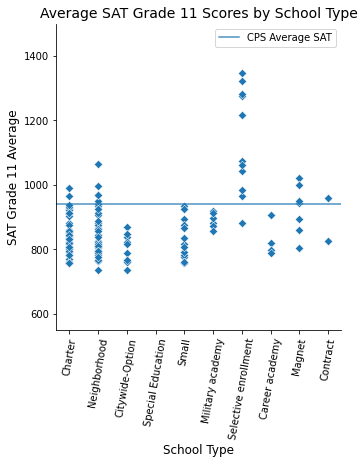

In [5]:
sb.relplot(data=hs_df, x='School_Type', y='SAT_Grade_11_Score_School_Avg', marker='D')
plt.ylim(550, 1500)
plt.xticks(rotation=80)
plt.xlabel('School Type', fontsize=12)
plt.ylabel('SAT Grade 11 Average', fontsize=12)
plt.axhline(y=hs_df['SAT_Grade_11_Score_CPS_Avg'].iloc[1], alpha=0.8, label='CPS Average SAT')
plt.legend()
plt.title('Average SAT Grade 11 Scores by School Type',fontsize=14)
plt.savefig('school_type_sat.png', dpi=600, bbox_inches='tight')
plt.show()

/Users/dbchristenson/Desktop/uchicago/SpringQuarter/DATA/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


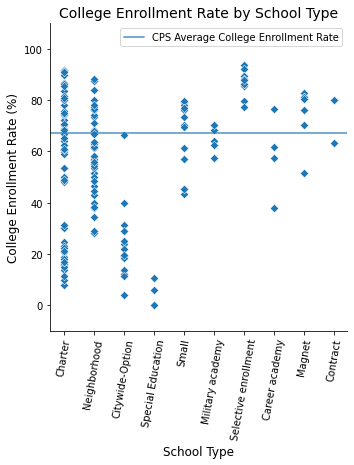

In [6]:
sb.relplot(hs_df.School_Type, hs_df.College_Enrollment_Rate_School, marker='D')
plt.ylabel('College Enrollment Rate (%)', fontsize=12)
plt.xlabel('School Type', fontsize=12)
plt.xticks(rotation=80)
plt.title('College Enrollment Rate by School Type', fontsize=14)
plt.ylim(-10, 110)
plt.axhline(y=hs_df.College_Enrollment_Rate_Mean.iloc[1], alpha=0.8, label='CPS Average College Enrollment Rate')
plt.legend()
plt.savefig('school_type_college_enrollment.png', dpi=600, bbox_inches='tight')
plt.show()

**What values should we target for making predictions?**

Ideas:

*Regression Models (Linear Reg)*
* SAT Score (SAT_Grade_11_Score_School_Avg)
* College Enrollment Rate (College_Enrollment_Rate_School)
* Suspensions (Suspensions_Per_100_Students_Year_1_Pct)
* Minority Ratio? (Minority_Ratio_School)
* Geographical Bias? (Lat & Long)
* Student Attendance (Student_Attendance_Year_1_Pct, Student_Attendance_Year_2_Pct)

*Classification Models (KNN, Logistic Regression)*
* Type of School

In [22]:
# First lets make the minority ratio column

# 3 Schools have 'Student_Count_Total' as 0.
# Replace the rows with Student_Count_Total = 0 with the median Student_Count_Total.
hs_df['Student_Count_Total'] = hs_df['Student_Count_Total'].replace({0: hs_df['Student_Count_Total'].median()})

hs_df['Minority_Ratio_School'] = 1 - (hs_df['Student_Count_White'] / hs_df['Student_Count_Total'])

In [23]:
print(((hs_df['Student_Count_White'] / hs_df['Student_Count_Total']) > 1).value_counts())
print('luckily none of the schools have a minority ratio greater than 1 (that would be impossible).')

False    178
dtype: int64
luckily none of the schools have a minority ratio greater than 1 (that would be impossible).


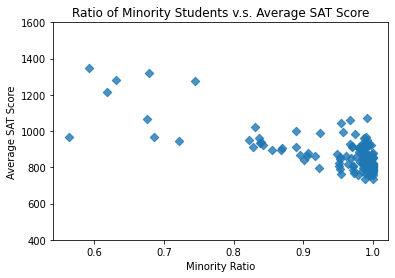

In [9]:
plt.scatter(hs_df['Minority_Ratio_School'], hs_df['SAT_Grade_11_Score_School_Avg'], alpha=0.8, marker='D')
plt.ylim(400, 1600)
plt.title('Ratio of Minority Students v.s. Average SAT Score')
plt.xlabel('Minority Ratio')
plt.ylabel('Average SAT Score')
plt.show()

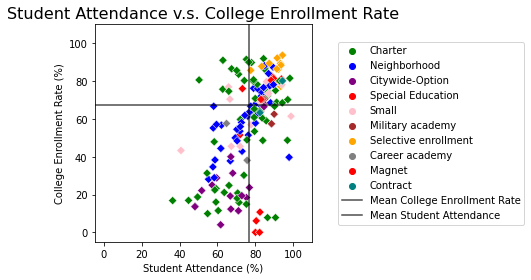

In [39]:
colors = ['green', 'blue', 'purple', 'red', 'pink', 'brown', 'orange', 'grey', 'red', 'teal']

sb.scatterplot(data=hs_df, x='Student_Attendance_Year_2_Pct', y='College_Enrollment_Rate_School', hue='School_Type', marker='D', palette=colors)
#plt.ylim(400, 1600)
fig = plt.gcf()
plt.ylabel('College Enrollment Rate (%)', fontsize=10)
plt.xlabel('Student Attendance (%)', fontsize=10)
plt.title('Student Attendance v.s. College Enrollment Rate', fontsize=16)
plt.axhline(y=hs_df.College_Enrollment_Rate_Mean.mean(), color='black', alpha=0.7, label='Mean College Enrollment Rate')
plt.axvline(x=hs_df.Student_Attendance_Year_2_Pct.mean(), color='black', alpha=0.7, label='Mean Student Attendance')

plt.legend(bbox_to_anchor=(2, 0.5), loc='center right')
plt.axis('square')
plt.xlim(-5, 110)
plt.ylim(-5, 110)

plt.savefig('student_attendance_college_enrollment_rate.png', dpi=600, bbox_inches='tight')

plt.show()

**Those are some pretty interesting visualizations about the trends of the data that we are going to be feeding to the ML model. The data being fed is obviously skewed and represents inequity in Chicago education so the model may develop certain biases because of this.**

In [11]:
# There are still some transformations to make to the dataset.

# Map School_Type to numbers
TYPE_MAP = {
    'Charter': 1,
    'Neighborhood': 2,
    'Citywide-Optional': 3,
    'Special Education': 4,
    'Small': 5,
    'Military academy': 6,
    'Selective enrollment': 7,
    'Career academy': 8,
    'Magnet': 9,
    'Contract': 10
}

hs_df['School_Type'] = hs_df['School_Type'].map(TYPE_MAP)

# Now drop every column that contains strings
cols_to_rm = []
for col in hs_df.columns:
    try:
        _ = hs_df[col].astype('float')
    except ValueError:
        cols_to_rm.append(col)

ml_hs_df = hs_df.drop(cols_to_rm, axis=1)

# Remove all schools (rows) where Average SAT for the school is NaN
ml_hs_df = ml_hs_df[~ml_hs_df['SAT_Grade_11_Score_School_Avg'].isnull()]

# Remove these annoying NaN columns
ml_hs_df.drop(['PreSchool_Inclusive', 'Title_1_Eligible', 'Excelerate_Award_Gold_Year'], axis=1, inplace=True)

# Replace each NaN value in a row with the median value of that column
for col in ml_hs_df.columns:
    ml_hs_df[col] = ml_hs_df[col].fillna(ml_hs_df[col].median())

In [12]:
print(f'Now we only have {ml_hs_df.shape[1]} columns and {ml_hs_df.shape[0]} rows.')

Now we only have 89 columns and 173 rows.


In [13]:
# Scramble the dataframe and select a training and testing set.
scrambled_hs = ml_hs_df.sample(frac=1, replace=False)

# Standardize the new dataframe
scrambled_hs = (scrambled_hs - scrambled_hs.mean()) / scrambled_hs.std()

split = round(0.8*len(scrambled_hs))
train_df = scrambled_hs[:split]
test_df = scrambled_hs[split:]

In [14]:
def get_train_data(target: str, df: pd.DataFrame=train_df):
    train_x = df.drop(target, axis=1)
    train_y = df[target]

    return (train_x, train_y)

def get_test_data(target: str, df: pd.DataFrame=test_df):
    test_x = df.drop(target, axis=1)
    test_y = df[target]

    return (test_x, test_y)

In [15]:
train_x, train_y = get_train_data('SAT_Grade_11_Score_School_Avg')

In [16]:
train_x.isna().sum().value_counts()

0      69
138    19
dtype: int64

In [17]:
from sklearn.linear_model import LinearRegression

def init_model(target: str='SAT_Grade_11_Score_School_Avg'):
    train_x, train_y = get_train_data(target)

    model = LinearRegression()
    model.fit(train_x, train_y)

    return model

ModuleNotFoundError: No module named 'sklearn'

In [ ]:
test_x, test_y = get_test_data('SAT_Grade_11_Score_School_Avg')

sat_model = init_model()
sat_model.predict(test_x)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
test_y

53        0.0
591       0.0
466     967.0
74        0.0
130     795.0
469       0.0
493     823.0
101     824.0
77      909.0
244     762.0
690     736.0
484     823.0
387     800.0
133     964.0
669       0.0
37      782.0
15      858.0
258     874.0
666     912.0
568     806.0
600     766.0
13        0.0
522     924.0
673     806.0
24        0.0
90      935.0
125    1042.0
359       0.0
663     847.0
544     735.0
543     886.0
392     835.0
480       0.0
380     792.0
345     912.0
Name: SAT_Grade_11_Score_School_Avg, dtype: float64

**Lets make a classification model**

In [ ]:
ml_hs_df.columns

Index(['School_ID', 'Legacy_Unit_ID', 'Finance_ID', 'Is_High_School',
       'Is_Middle_School', 'Is_Elementary_School', 'Is_Pre_School', 'Zip_x',
       'Attendance_Boundaries', 'Student_Count_Total',
       'Student_Count_Low_Income', 'Student_Count_Special_Ed',
       'Student_Count_English_Learners', 'Student_Count_Black',
       'Student_Count_Hispanic', 'Student_Count_White', 'Student_Count_Asian',
       'Student_Count_Native_American', 'Student_Count_Other_Ethnicity',
       'Student_Count_Asian_Pacific_Islander', 'Student_Count_Multi',
       'Student_Count_Hawaiian_Pacific_Islander',
       'Student_Count_Ethnicity_Not_Available', 'Dress_Code',
       'Bilingual_Services', 'Refugee_Services',
       'College_Enrollment_Rate_School', 'College_Enrollment_Rate_Mean',
       'Graduation_Rate_School', 'Graduation_Rate_Mean',
       'Is_GoCPS_Participant', 'Is_GoCPS_PreK', 'Is_GoCPS_Elementary',
       'Is_GoCPS_High_School', 'School_Latitude_x', 'School_Longitude_x',
       'Schoo

In [ ]:
important_metrics = ['Student_Count_Total', 'Student_Count_Low_Income', 'Student_Count_Special_Ed', 
                     'Graduation_Rate_School', 'School_Latitude_x', 
                     'School_Longitude_x', 'School_Latitude_y', 'School_Longitude_y', 'Minority_Ratio_School', 
                     'Suspensions_Per_100_Students_Year_1_Pct', 'SAT_Grade_11_Score_School_Avg']

print(f'We have identified {len(important_metrics)} important metrics to classifying the school type.')

clf_x_df = ml_hs_df.filter(important_metrics)
clf_y_df = ml_hs_df['School_Type']

We have identified 11 important metrics to classifying the school type.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

# Invert the TYPE_MAP to get the school type names back
TYPE_MAP_INV = {v: k for k, v in TYPE_MAP.items()}

In [ ]:
def split_data(x_df: pd.DataFrame, y_df: pd.DataFrame, test_size: float=0.2):
    split = round(len(x_df)*test_size)

    train_x = x_df[:split]
    train_y = y_df[:split]

    test_x = x_df[split:]
    test_y = y_df[split:]

    return (train_x, train_y, test_x, test_y)


def clf_knn(n: int, train_x, train_y):
    '''Instantiates a KNN model with n neighbors targeting School_Type.'''

    clf = KNN(n_neighbors=n).fit(train_x, train_y)

    return clf


def score_knn(n: int, train_x, train_y, test_x, test_y):
    '''Scores the KNN model.'''

    return_pa = True

    clf = clf_knn(n, train_x, train_y)
    score = clf.score(test_x, test_y)

    try:
        predicted = list(map(lambda x: TYPE_MAP_INV[x], clf.predict(test_x)))
        actual = list(map(lambda x: TYPE_MAP_INV[x], test_y))
    except KeyError:
        return_pa = False

    if return_pa:
        return (score, predicted, actual)
    else:
        return score

In [ ]:
train_x, train_y, test_x, test_y = split_data(clf_x_df, clf_y_df)

In [ ]:
# Lets create a variable for determining if a school's college enrollment rate is higher than the mean, 1 if true, 0 if false
ml_hs_df['enrollment_b'] = np.where(ml_hs_df['College_Enrollment_Rate_School'] > ml_hs_df.College_Enrollment_Rate_Mean.iloc[1], 1, 0)

In [ ]:
y_df = ml_hs_df['enrollment_b']
x_df = ml_hs_df.filter(important_metrics)

In [ ]:
train_x, train_y, test_x, test_y = split_data(x_df, y_df, 0.2)

In [ ]:
score_knn(7, train_x, train_y, test_x, test_y)

0.717391304347826

In [ ]:
train_x

,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,College_Enrollment_Rate_School,Graduation_Rate_School,School_Latitude_x,School_Longitude_x,School_Latitude_y,School_Longitude_y,Minority_Ratio_School,Suspensions_Per_100_Students_Year_1_Pct,SAT_Grade_11_Score_School_Avg,School_Type
2,182.0,158,48,56.70,62.00,41.807510,-87.642966,41.807510,-87.642966,0.923077,13.3,794.0,2.0
5,161.0,124,26,63.55,80.65,41.695105,-87.642816,41.695105,-87.642816,0.993789,4.8,0.0,2.0
7,378.0,315,378,0.00,80.65,41.759852,-87.675947,41.759852,-87.675947,0.949735,1.0,0.0,4.0
13,141.0,123,33,15.80,80.65,41.841331,-87.625331,41.841331,-87.625331,1.000000,4.8,0.0,1.0
15,252.0,209,63,83.60,81.10,41.734622,-87.556201,41.734622,-87.556201,1.000000,4.8,858.0,1.0
19,285.0,183,50,23.70,8.70,41.939433,-87.705206,41.939433,-87.705206,0.894737,4.8,868.0,2.0
21,62.0,58,8,79.30,92.50,41.806118,-87.625030,41.806118,-87.625030,1.000000,10.6,816.0,5.0
24,210.0,185,210,10.70,80.65,41.849675,-87.625315,41.849675,-87.625315,0.952381,0.7,0.0,4.0
25,322.0,230,48,19.20,10.00,41.735239,-87.704060,41.735239,-87.704060,0.900621,4.8,838.0,2.0
29,138.0,123,42,30.20,80.65,41.902850,-87.696006,41.902850,-87.696006,0.978261,4.8,758.0,1.0


In [ ]:
knn_scores = []

for i in range(1,21):
    score = score_knn(i, train_x, train_y, test_x, test_y)
    knn_scores.append(score)

In [ ]:
knn_scores

[0.717391304347826,
 0.6956521739130435,
 0.717391304347826,
 0.6956521739130435,
 0.7246376811594203,
 0.717391304347826,
 0.717391304347826,
 0.717391304347826,
 0.7608695652173914,
 0.717391304347826,
 0.717391304347826,
 0.6956521739130435,
 0.6956521739130435,
 0.6956521739130435,
 0.7028985507246377,
 0.6956521739130435,
 0.7318840579710145,
 0.7318840579710145,
 0.7101449275362319,
 0.7028985507246377]

In [ ]:
knn_no_st_scores = []

for i in range(1,21):
    score = score_knn(i, train_x, train_y, test_x, test_y)
    knn_no_st_scores.append(score)

In [ ]:
knn_no_st_scores

[0.7246376811594203,
 0.7028985507246377,
 0.7246376811594203,
 0.7101449275362319,
 0.7246376811594203,
 0.717391304347826,
 0.717391304347826,
 0.717391304347826,
 0.7608695652173914,
 0.717391304347826,
 0.717391304347826,
 0.6956521739130435,
 0.6956521739130435,
 0.6956521739130435,
 0.7028985507246377,
 0.6956521739130435,
 0.7318840579710145,
 0.7318840579710145,
 0.7101449275362319,
 0.7028985507246377]

Text(0.5, 1.0, 'KNN Accuracy vs. Number of Neighbors')

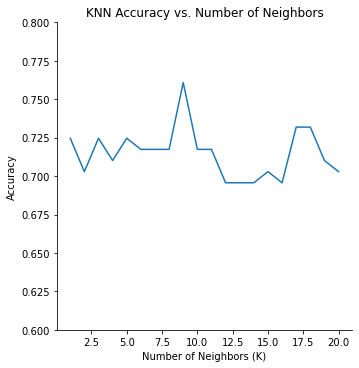

In [ ]:
sb.relplot(x=np.arange(1,21), y=knn_scores, kind='line')
plt.ylim(0.6, 0.8)
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy vs. Number of Neighbors')

/var/folders/46/vx3njgs97gvfp07b3lv4l9rc0000gn/T/ipykernel_6535/2399273791.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


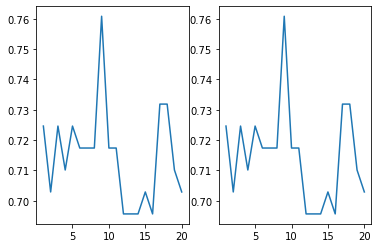

In [ ]:
fig, ax = plt.subplots(1,2)
sb.lineplot(x=np.arange(1,21), y=knn_scores, ax=ax[0])
sb.lineplot(x=np.arange(1,21), y=knn_no_st_scores, ax=ax[1])
fig.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
clf = model.fit(train_x, train_y)

In [ ]:
clf.score(test_x, test_y)

0.4782608695652174

In [ ]:
no_type_metrics = important_metrics[:-1]

In [ ]:
school_type_nn = MLPClassifier().fit(ml_hs_df.filter(important_metrics), ml_hs_df.enrollment_b)
no_school_type_nn = MLPClassifier().fit(ml_hs_df.filter(no_type_metrics), ml_hs_df.enrollment_b)

/Users/dbchristenson/Desktop/uchicago/SpringQuarter/ML/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
school_type_nn.score(test_x, test_y)

0.717391304347826

In [ ]:
test_x.iloc[:,:-1]

,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Graduation_Rate_School,School_Latitude_x,School_Longitude_x,School_Latitude_y,School_Longitude_y,Minority_Ratio_School,Suspensions_Per_100_Students_Year_1_Pct
134,199.0,191,79,73.00,41.886210,-87.715423,41.886210,-87.715423,0.994975,9.3
140,1431.0,1105,238,86.90,41.954764,-87.668953,41.954764,-87.668953,0.907058,5.6
142,556.0,482,117,63.90,41.823880,-87.619796,41.823880,-87.619796,0.998201,6.8
145,540.0,479,44,95.80,41.879118,-87.686960,41.879118,-87.686960,0.970370,1.1
147,125.0,94,32,80.65,41.902841,-87.687946,41.902841,-87.687946,0.968000,4.8
...,...,...,...,...,...,...,...,...,...,...
680,99.0,83,24,80.65,41.832072,-87.626781,41.832072,-87.626781,0.979798,4.8
682,617.0,313,50,86.10,41.899377,-87.694945,41.899377,-87.694945,0.836305,1.0
683,2247.0,1305,116,93.30,41.803772,-87.590421,41.803772,-87.590421,0.957276,6.4
688,168.0,134,42,79.60,41.748382,-87.668980,41.748382,-87.668980,1.000000,4.8


In [ ]:
no_school_type_nn.score(test_x.iloc[:,:-1], test_y)

0.8260869565217391

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(test_y, school_type_nn.predict(test_x))

array([[57, 25],
       [14, 42]])

In [ ]:
confusion_matrix(test_y, no_school_type_nn.predict(test_x.iloc[:,:-1]))

array([[71, 11],
       [13, 43]])

In [ ]:
from sklearn.metrics import plot_confusion_matrix

/Users/dbchristenson/Desktop/uchicago/SpringQuarter/ML/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


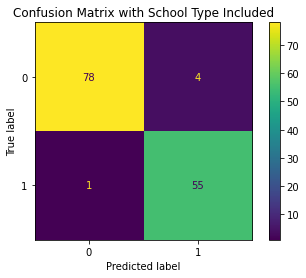

In [ ]:
plot_confusion_matrix(school_type_nn, test_x, test_y)
plt.title('Confusion Matrix with School Type Included')
plt.savefig('confusion_matrix_school_type.png', dpi=600, bbox_inches='tight')
plt.show()

/Users/dbchristenson/Desktop/uchicago/SpringQuarter/ML/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


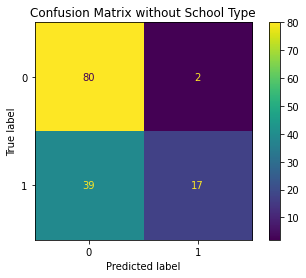

In [ ]:
plot_confusion_matrix(no_school_type_nn, test_x.iloc[:,:-1], test_y)
plt.title('Confusion Matrix without School Type')
plt.savefig('confusion_matrix_no_school_type.png', dpi=600, bbox_inches='tight')
plt.show()